## Association rule mining and co-morbidities analysis for COVID-19 patients



In [3]:
!pip install mlxtend

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/1c/07/512f6a780239ad6ce06ce2aa7b4067583f5ddcfc7703a964a082c706a070/mlxtend-0.23.1-py3-none-any.whl.metadata
  Using cached mlxtend-0.23.1-py3-none-any.whl.metadata (7.3 kB)
Using cached mlxtend-0.23.1-py3-none-any.whl (1.4 MB)


In [4]:
import os
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
from mlxtend.preprocessing import TransactionEncoder

## We will use the package [`mlxtend`](http://rasbt.github.io/mlxtend/) to do association rule mining.
* To install `mlxtend` you can `pip install mlxtend`

## In the next cell, we set up to connect to the COVID-19 database

In [6]:
"""with open("credentials.txt") as cred_file:
    myUserName = cred_file.readline().strip()
    myPassword = cred_file.readline().strip()
# print(myUserName)
# print(myPassword)

"""
myUserName = 'ashv'
myPassword = 

server_url = "chip690-primary"
database = "omop_covid"

# Create Connection String
conn_str = f"{myUserName}:{myPassword}@{server_url}/{database}"

# Create Engine
engine = sqlalchemy.create_engine('postgresql://' + conn_str)

## In the next cell is a function that returns a data frame of patient_id and conditions associated with the patient from the COVID EHR database.
* The SQL query used in the function is provided by Dr. Emily Pfaff (thank you, Emily !).

In [7]:
def get_comorbid_data():
    query = '''
    --conditions
select person_id, string_agg(cond_name, ',') as cond_names
from
(select distinct co.person_id, con.concept_name as cond_name
from condition_occurrence co JOIN concept con ON co.condition_concept_id = con.concept_id) as sub
group by person_id'''
    
    return pd.read_sql_query(query, engine)

### In the next cell, use the function `get_comorbid_data` to get the dataframe with the comorbidities associated with each patient.
* I also suggest that you use `head` to examine the returned data frame. You should see that the dataframe has two columns, the `person_id` and `cond_names`.


In [8]:
# looking at the dataframe
comorb_df = get_comorbid_data()
comorb_df.head(30)
comorb_df.shape

(121701, 2)

### The data frame returns the comorbidities for a patient in the `cond_names` column as a comma separated string.
### In the cell below write code that adds another column to the dataframe that has the comorbidities as a list of strings.
* For example if the `cond_names` column has 'COVID-19,Cough,Chronic simusitis' the new column will have `['COVID-19', 'Cough', 'Chronic simusitis']

In [9]:
# adding another column with the comorbidities as a list of strings
comorb_df['names_list'] = comorb_df['cond_names'].str.split(',')
comorb_df.head(5)

,person_id,cond_names,names_list
0,24155,"Miscarriage in first trimester,Atrial fibrilla...","[Miscarriage in first trimester, Atrial fibril..."
1,25063,"Traumatic brain injury,Cough,Fatigue,Miscarria...","[Traumatic brain injury, Cough, Fatigue, Misca..."
2,24545,"COVID-19,Cough,Chronic sinusitis,Cerebrovascul...","[COVID-19, Cough, Chronic sinusitis, Cerebrova..."
3,21210,"Closed fracture of hip,COVID-19,Chill,Loss of ...","[Closed fracture of hip, COVID-19, Chill, Loss..."
4,28920,"Fever,Sputum finding,Pneumonia,COVID-19,Hyperl...","[Fever, Sputum finding, Pneumonia, COVID-19, H..."


### In the cell below write code that prints out the the number of unique comorbidities across all patients.

In [11]:
# prints the number of unique comorbidities 
flat_list = comorb_df['names_list'].explode()

unique_names = flat_list.unique()  
num_unique_names = len(unique_names) 
print(num_unique_names)

176


### Create a barchart of the count (or frequenncy) of each of the unique comorbidities, similar to Figure 2 in the Ma et al paper.

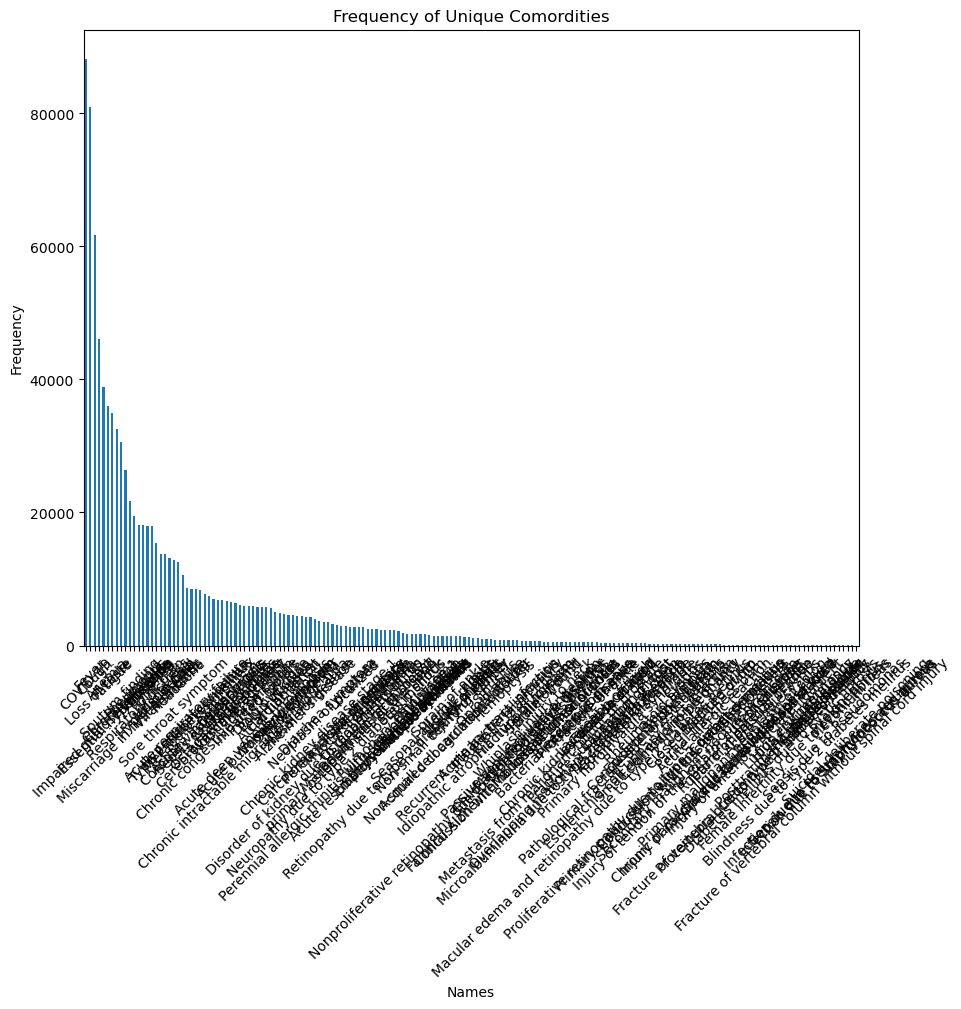

In [12]:
#creating a barchart of each unique comorbidity
name_frequencies = flat_list.value_counts()

plt.figure(figsize=(10, 8))  
name_frequencies.plot(kind='bar')
plt.title('Frequency of Unique Comordities')
plt.xlabel('Names')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  
plt.show()

## oops, too many conditions to plot, just plot the top 30 comorbid conditions

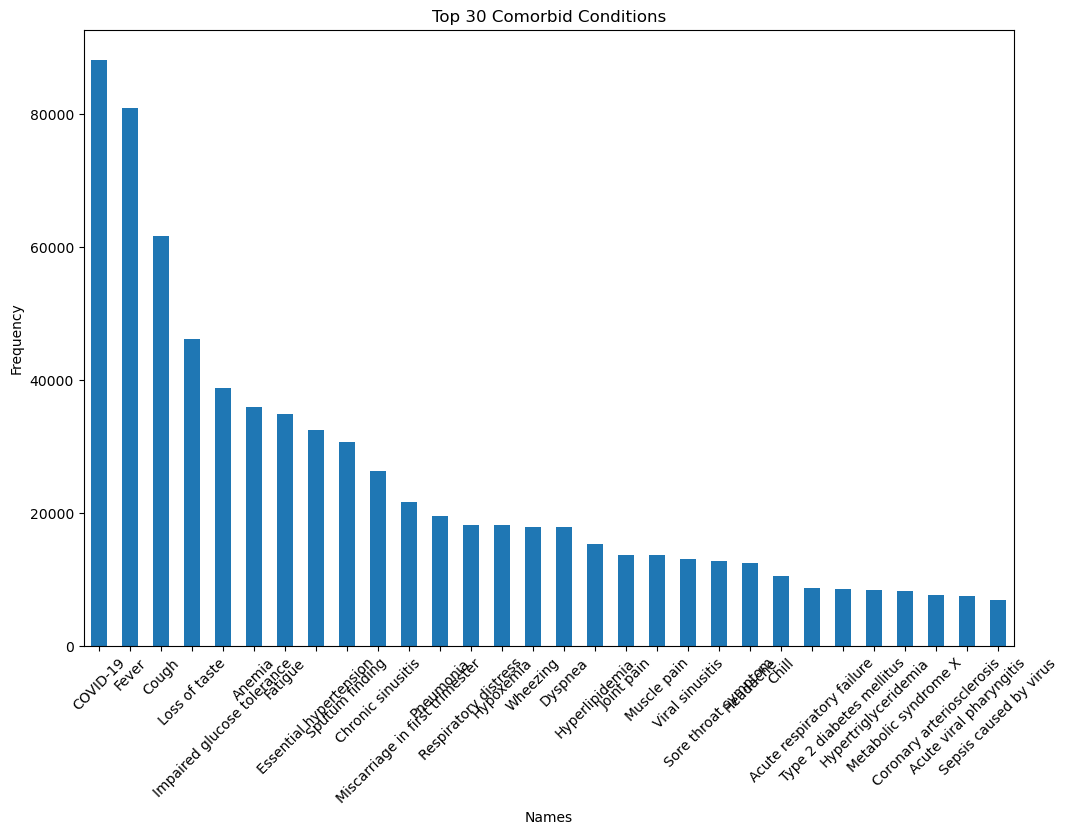

In [13]:
#plotting the top 30 comorbid conditions 
top_30_names = name_frequencies.head(30)

plt.figure(figsize=(12, 8))  
top_30_names.plot(kind='bar')
plt.title('Top 30 Comorbid Conditions')
plt.xlabel('Names')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  
plt.show()

### To prepare for frequent itemset computation, we want to convert the comorbidities acorss all patients into a list of lists.
* The inner list should have all the comorbidities associated with a patient as a list.
* The outer list simply holds all the inner lists.
* You can check that you are on the right track by confirming that the number of inner lists is the same as the number of patients.
* You can also try to print out a few of the inner lists to check.

In [14]:
#preparing for frequent itemset computation
comorbidities_list_of_lists = comorb_df['names_list'].tolist()

print(f"Total patients: {len(comorbidities_list_of_lists)}")
for comorbidities in comorbidities_list_of_lists[:3]:  
    print(comorbidities)

Total patients: 121701
['Miscarriage in first trimester', 'Atrial fibrillation', 'Sore throat symptom', 'Fever', 'Loss of taste', 'Chronic sinusitis', 'Impaired glucose tolerance', 'Anemia', 'Headache', 'Cough', 'Gout', 'Primary fibromyalgia syndrome', 'COVID-19']
['Traumatic brain injury', 'Cough', 'Fatigue', 'Miscarriage in first trimester', 'Loss of taste', 'Fever', 'COVID-19', 'Headache']
['COVID-19', 'Cough', 'Chronic sinusitis', 'Cerebrovascular accident', 'Miscarriage in first trimester', 'Localized', ' primary osteoarthritis of the hand', 'Acute pulmonary embolism', 'Fever', 'Hyperlipidemia', 'Respiratory distress', 'Acute respiratory failure', 'Atrial fibrillation', 'Sepsis caused by virus', 'Appendicitis', 'Essential hypertension', 'Fatigue', 'Loss of taste', 'Pneumonia', 'Hypoxemia', 'Nasal congestion']


In [15]:
#checking the number of rows
num_rows = comorb_df.shape[0]
num_rows

121701

### To use the `mlxtend`'s `aprori` function, you need to one-hot encode the list of conditions.
* `mlxtend` provides a method called `TransactionEncoder` that will take the list of lists and create a one-hot encoded data frame.
* Create the one-hot encoded data frame from your list of lists and look at the first 25 items using the `head` method.

In [16]:
# One-hot encode 
from mlxtend.preprocessing import TransactionEncoder
encoder = TransactionEncoder()

one_hot = encoder.fit_transform(comorbidities_list_of_lists)

one_hot_df = pd.DataFrame(one_hot, columns=encoder.columns_)

print(one_hot_df.head(25))

     TNM stage 1   primary osteoarthritis of the hand   single episode  \
0          False                                False            False   
1          False                                False            False   
2          False                                 True            False   
3          False                                False            False   
4          False                                False            False   
5          False                                False            False   
6          False                                False            False   
7          False                                False            False   
8          False                                False            False   
9          False                                False            False   
10         False                                False            False   
11         False                                False            False   
12         False                      

### Now use the `mlxtend`'s `apriori` method to find the frequent itemsets in your data.
* Try different `min_sup` values and make an informed judgement on the `min_sup` values that you will retain for furthe analysis.
* In the markdown cell below, explain your reason for choosing the `min_sup` value that you did.
* Use the `head` method to look at the first 25 itemsets.

In [27]:
# trying different min_sup values to see which produces the best set of itemsets
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(one_hot_df, min_support=0.2, use_colnames=True)

print(frequent_itemsets)


     support                                 itemsets
0   0.295577                                 (Anemia)
1   0.724448                               (COVID-19)
2   0.216580                      (Chronic sinusitis)
3   0.507062                                  (Cough)
4   0.267541                 (Essential hypertension)
5   0.287187                                (Fatigue)
6   0.664456                                  (Fever)
7   0.318822             (Impaired glucose tolerance)
8   0.378970                          (Loss of taste)
9   0.251871                         (Sputum finding)
10  0.257796     (Impaired glucose tolerance, Anemia)
11  0.491089                        (COVID-19, Cough)
12  0.278182                      (COVID-19, Fatigue)
13  0.643717                        (COVID-19, Fever)
14  0.209053   (COVID-19, Impaired glucose tolerance)
15  0.366850                (COVID-19, Loss of taste)
16  0.243761               (COVID-19, Sputum finding)
17  0.450530                

### Explanation for the `min_sup` value that you chose should be entered here in this markdown cell.

* In the previous cell, we looked at the number of itemsets and the largest itemset count for a variety of min_sup levels.
* A min_sup level of 0.2 appears to provide the right balance between number of itemsets (29) and maximum number of items per itemset (4).
* A larger min_sup reduces the larger itemset size to 3, which is on the border of what is requested in the subsequent questions.

I chose a min_sup level of 0.2 because when the min_sup is less than 0.2, we get a large amount of itemsets (155). With 155 itemsets, it is difficult to pinpoint how useful and relevant these itemsets are. When min_sup is 0.2, the amount of itemsets are 29, which is a more managable amount of itemsets to analyze. When min_sup is 0.3, this reduces the amount of itemsets to 11. We can work these 11 itemsets; however, only 2 of the 11 contain at least 3 items (which is not as useful for the subsquent questions). When min_sup is 0.2, we have the right balance. 

### Now add a column called `count` to your frequent itemsets dataframe that is a count of the number of items in that itemset.
* Again, use `head` to see the first 25 frequent itemsets.

In [28]:
# adding a new column that shows the frequency of the itemset
frequent_itemsets['count'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(frequent_itemsets.head(25))


     support                                itemsets  count
0   0.295577                                (Anemia)      1
1   0.724448                              (COVID-19)      1
2   0.216580                     (Chronic sinusitis)      1
3   0.507062                                 (Cough)      1
4   0.267541                (Essential hypertension)      1
5   0.287187                               (Fatigue)      1
6   0.664456                                 (Fever)      1
7   0.318822            (Impaired glucose tolerance)      1
8   0.378970                         (Loss of taste)      1
9   0.251871                        (Sputum finding)      1
10  0.257796    (Impaired glucose tolerance, Anemia)      2
11  0.491089                       (COVID-19, Cough)      2
12  0.278182                     (COVID-19, Fatigue)      2
13  0.643717                       (COVID-19, Fever)      2
14  0.209053  (COVID-19, Impaired glucose tolerance)      2
15  0.366850               (COVID-19, Lo

### Now create a new data frame of itemsets sorted by the support in descending order.
* Print out the highest and lowest support and the count associated with each.
* Again examine the first 25 rows using `head`.

In [29]:
#sorting the itemsets in terms of support
sorted_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

highest_support = sorted_itemsets.iloc[0]
print(f"High Support: {highest_support['support']}, Count: {highest_support['count']}")

lowest_support = sorted_itemsets.iloc[-1]
print(f"Low Support: {lowest_support['support']}, Count: {lowest_support['count']}")

print(sorted_itemsets.head(25))


High Support: 0.7244476216300606, Count: 1
Low Support: 0.20905333563405396, Count: 2
     support                              itemsets  count
1   0.724448                            (COVID-19)      1
6   0.664456                               (Fever)      1
13  0.643717                     (COVID-19, Fever)      2
3   0.507062                               (Cough)      1
11  0.491089                     (COVID-19, Cough)      2
17  0.450530                        (Fever, Cough)      2
22  0.436545              (COVID-19, Fever, Cough)      3
8   0.378970                       (Loss of taste)      1
15  0.366850             (COVID-19, Loss of taste)      2
20  0.336300                (Fever, Loss of taste)      2
25  0.325683      (COVID-19, Fever, Loss of taste)      3
7   0.318822          (Impaired glucose tolerance)      1
0   0.295577                              (Anemia)      1
5   0.287187                             (Fatigue)      1
12  0.278182                   (COVID-19, Fa

###  Filter your sorted array of frequent itemsets to only show rows that have a count of at least 3.
* What are the co-occuring conditions that have the highest support in this filtered list?

In [30]:
# Show the itemsets with the count of three
filtered_itemsets = sorted_itemsets[sorted_itemsets['count'] >= 3]
filtered_itemsets

,support,itemsets,count
22,0.436545,"(COVID-19, Fever, Cough)",3
25,0.325683,"(COVID-19, Fever, Loss of taste)",3
23,0.248733,"(COVID-19, Cough, Loss of taste)",3
24,0.247254,"(COVID-19, Fever, Fatigue)",3
27,0.228092,"(Fever, Cough, Loss of taste)",3
28,0.220886,"(COVID-19, Fever, Cough, Loss of taste)",4
26,0.216243,"(COVID-19, Fever, Sputum finding)",3


In [31]:
#identifying which itemset of three has the highest support 
highest_support_conditions = filtered_itemsets.iloc[0]

print("Co-occurring conditions with the highest support:")
print(f"Itemset: {highest_support_conditions['itemsets']}, Support: {highest_support_conditions['support']}")

Co-occurring conditions with the highest support:
Itemset: frozenset({'COVID-19', 'Fever', 'Cough'}), Support: 0.4365453036540374


### Feel free to come up with other interesting things to try with this data.
* For example, compute association rules from the 3 itemsets and see if the high confidence ones have any interesting information.

In [32]:
from mlxtend.frequent_patterns import association_rules



In [33]:
#computing confidence in frequenct itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Impaired glucose tolerance),(Anemia),0.318822,0.295577,0.257796,0.808587,2.735625,0.163559,3.680130,0.931406
1,(Anemia),(Impaired glucose tolerance),0.295577,0.318822,0.257796,0.872178,2.735625,0.163559,5.329126,0.900670
2,(COVID-19),(Cough),0.724448,0.507062,0.491089,0.677880,1.336878,0.123749,1.530294,0.914484
3,(Cough),(COVID-19),0.507062,0.724448,0.491089,0.968498,1.336878,0.123749,8.747087,0.511197
4,(Fatigue),(COVID-19),0.287187,0.724448,0.278182,0.968642,1.337076,0.070130,8.787255,0.353669


### Here we are visualizing support vs confidence. 
We want itemsets with a high support and high confidence. 

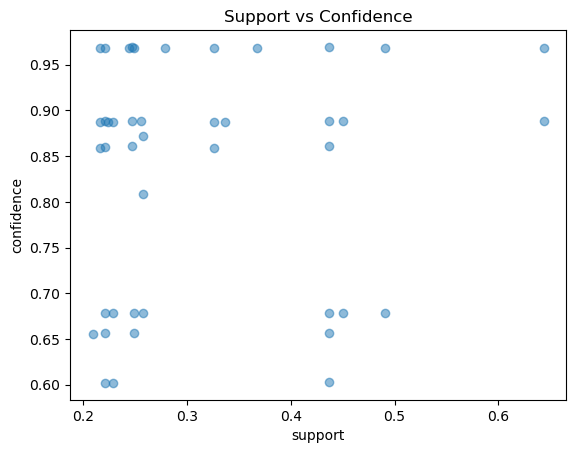

In [36]:
#visualizing support vs confidence 
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

### Here we are visualizing support vs lift. 
We want itemsets with a high support and high lift. 

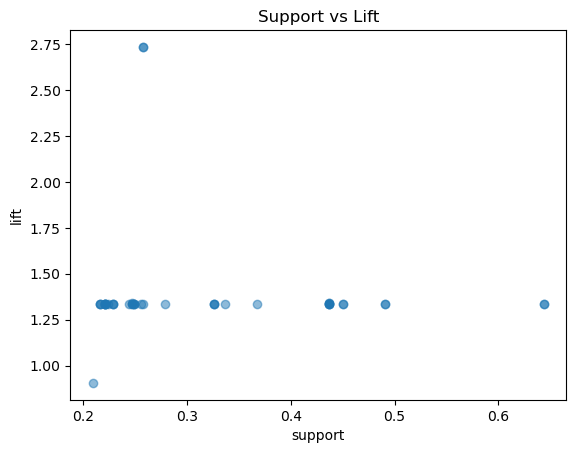

In [37]:
#visualizing support vs lift 
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()